In [1]:
"""
This project was developed by Peter Chen, Rocky Duan, Pieter Abbeel for the Berkeley Deep RL Bootcamp, August 2017.
Bootcamp website with slides and lecture videos: https://sites.google.com/view/deep-rl-bootcamp/.

Code adapted from Stanford CS231N materials: http://cs231n.stanford.edu/
"""


# note to properly run this lab, you should execute all code blocks sequentially
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

from collections import namedtuple, defaultdict, deque

import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

## Introduction to Chainer

Chainer can be understood as Numpy plus the ability to record the computation graph of numerical operations to enable Automatic Differentiation. (Chainer actually also offers many other things; for example, a Numpy equivalent library that runs on GPU, but we will ignore them for now)

Let's illustrate how Chainer works by a simple 1D regression task.

Suppose we have observations from the following model $y = w x + b + \epsilon$ where $\epsilon \sim \mathcal{N}(0, 0.1)$ and the task is to estimate the linear model parameters $w, b$ from data.

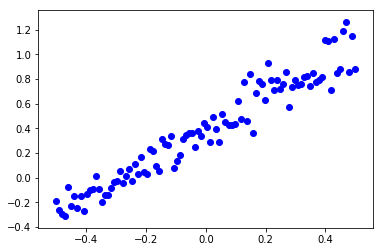

In [2]:
# first generate some observations
true_a = 1.3
true_b = 0.4
data_x = (np.arange(100) / 99.0 - .5).astype(np.float32) # Chainer assumes all the cpu computation is done in float32
data_y = (data_x * true_a + true_b + np.random.randn(*data_x.shape) * 0.1).astype(np.float32)
_ = plt.scatter(data_x, data_y, c='b')

Chainer provides an abstraction called `Link` that describe some computation and keeps track of parameters for it. For instance, a `Linear` link describes a linear map on input and keeps track of `w` and bias `b`.

In [3]:
model = L.Linear(in_size=1, out_size=1) # input is 1D data and output is also 1D data

# Chainer will randomly initialize `w` and `b` for us.
# we can take a look at their values
print("w:", model.W)
print("b:", model.b)

# model.W and model.b have type `chainer.Variable`, 
#   which is a wrapper around Numpy array
assert isinstance(model.W, chainer.Variable)

# operations that involve `chainer.Variable` will produce
#   `chainer.Variable` and this records the computation graph
var_result = model.W + 123 # some random computation
print("Operations on chainer.Variable: %s, type: %s" % (var_result, type(var_result)))

# the underlying numpy array can be accessed by `data` attribute
print("numpy arrays:", model.W.data, var_result.data)

w: variable W([[ 0.52466244]])
b: variable b([ 0.])
Operations on chainer.Variable: variable([[ 123.52466583]]), type: <class 'chainer.variable.Variable'>
numpy arrays: [[ 0.52466244]] [[ 123.52466583]]


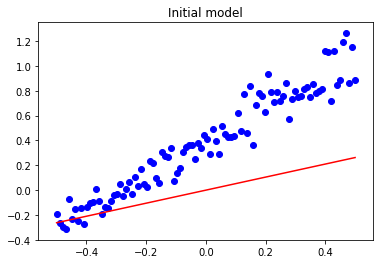

In [4]:
# A chainer link is a callable object. calling it performs the
#   forward computation. (in this case, it performs Wx + b)
model_y = model(data_x[:, None]) # chainer's link usually assumes input is [Batch Size, Input Dimension]
# `model_y` is a chainer variable so we use `.data` to access its numpy array for plotting

# we can plot the model's current fit in red. it should be terrible because we haven't trained it yet
_ = plt.plot(data_x, model_y.data[:,0], c='r')
_ = plt.scatter(data_x, data_y, c='b')
_ = plt.title("Initial model")

In [5]:
# now let's walk through how to perform forward computation
#  and use AD to get gradients

# first we clear the gradients that are stored in the model
model.cleargrads()
# as we have seen we can perform forward computation by calling the link
model_y = model(data_x[:, None])

# remember that `model_y` is a chainer variable. to operate on chainer variable
#    we will use functions from chainer.functions to operate on those objects.
loss = F.mean(F.square(model_y - data_y[:, None]))
# `loss` is a scalar chainer variable
assert isinstance(loss, chainer.Variable)
print("loss", loss)
# calculating gradients d loss /d params is as simple as
loss.backward()

# we can inspect the gradient of loss with respect to W
print("dloss/dW", model.W.grad)

loss variable(0.21862977743148804)
dloss/dW [[-0.14019029]]


Now that we know how to calculate gradients, we can code up a simple loop to perform gradient descent to train this model:

(Hint: if you run into weird problems, maybe the state has been messed up and you can try re-runing all the code blocks from the beginning)

Itr 0 loss: variable(0.1777813881635666)
       dloss/dW [[-0.07590858]]
       dloss/db [-0.77377421]

Itr 25 loss: variable(0.013086672872304916)
       dloss/dW [[-0.02562506]]
       dloss/db [ -1.67638063e-08]

Itr 50 loss: variable(0.011375797912478447)
       dloss/dW [[-0.00865045]]
       dloss/db [ -1.02445483e-08]

Itr 75 loss: variable(0.011180826462805271)
       dloss/dW [[-0.0029202]]
       dloss/db [ -1.09430403e-08]



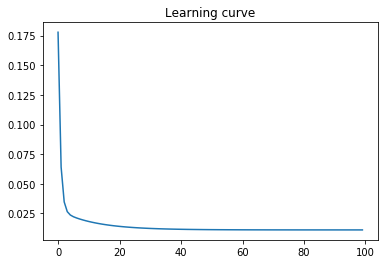

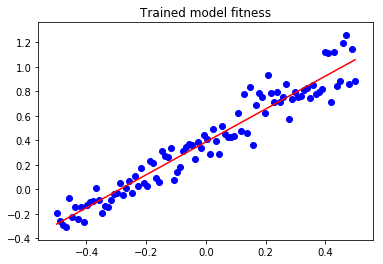

In [6]:
# now we can perform gradient descent to improve this model
model = L.Linear(in_size=1, out_size=1)
losses = []

alpha = 0.25 # learning rate

for i in range(100):
    model.cleargrads()
    loss = F.mean(F.square(model(data_x[:, None]) - data_y[:, None]))
    losses.append(float(loss.data))
    ## *** YOUR CODE HERE TO PERFORM GRADIENT DESCENT ***
    ## Hint: you could access gradients with model.W.grad, model.b.grad
    ## Hint2: you could write data into a parameter with model.W.data[:] = some_numpy_array
    ## Hint3: if your model doesn't learn, remember to try different learning rates
    loss.backward()
    model.W.data[:] = model.W.data[:] - alpha*model.W.grad
    model.b.data[:] = model.b.data[:] - alpha*model.b.grad
    if i % 25 == 0:
        print("Itr", i, "loss:", loss)
        print("       dloss/dW", model.W.grad)
        print("       dloss/db", model.b.grad)
        print()

plt.plot(np.array(losses))
plt.title("Learning curve")
plt.figure()
plt.plot(data_x, model(data_x[:, None])[:,0].data, c='r')
plt.scatter(data_x, data_y, c='b')
_ = plt.title("Trained model fitness")


## Train your first deep model

Now we have learned the basics of Chainer. We can use it to train a deep model to classify MNIST digits. We will train a model on the MNIST dataset because the dataset is small.

First we load the data and see what the images look like:

train[i][0] is the ith image that's flattened, and has shape: (784,)
train[i][1] is the ith image's label, such as: 3


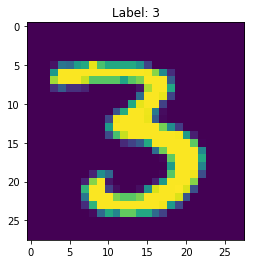

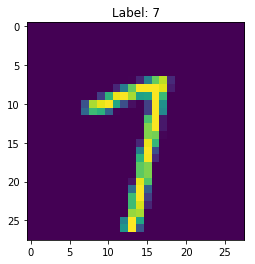

In [7]:
train, test = chainer.datasets.get_mnist()
# use train[data_point_index] to access data
print("train[i][0] is the ith image that's flattened, and has shape:", train[12][0].shape)
print("train[i][1] is the ith image's label, such as:", train[12][1])
# here we visualize two of them
plt.imshow(train[12][0].reshape([28, 28,]))
plt.title("Label: %s" % train[12][1])
plt.figure()
plt.imshow(train[42][0].reshape([28, 28,]))
_ = plt.title("Label: %s" % train[42][1])

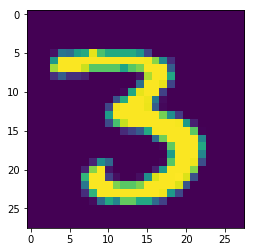

In [8]:
train2d, test2d = chainer.datasets.get_mnist(ndim=2)
plt.imshow(train2d[12][0])

Next we will provide some boilerplate code and train a linear classifier as an example:

In [9]:
def run(model, batchsize=16, num_epochs=2):
    
    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
        
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

# try a simple linear model
run(L.Linear(None, 10))

accuracy: 0.25; loss: 2.3868432045
accuracy: 0.8575; loss: 0.587937524319
accuracy: 0.8875; loss: 0.448141825199
accuracy: 0.87; loss: 0.527222963572
accuracy: 0.895; loss: 0.404154541492
accuracy: 0.895; loss: 0.390572462082
accuracy: 0.915; loss: 0.313278905153
accuracy: 0.9125; loss: 0.294300355613
accuracy: 0.895; loss: 0.393620715141
accuracy: 0.9075; loss: 0.301302659214
accuracy: 0.92; loss: 0.30132411927
accuracy: 0.905; loss: 0.300758013427
accuracy: 0.9175; loss: 0.315130329728
accuracy: 0.925; loss: 0.327230236232
accuracy: 0.8975; loss: 0.335583413243
accuracy: 0.8925; loss: 0.346109972
accuracy: 0.935; loss: 0.288659181595
accuracy: 0.9125; loss: 0.331015142724
accuracy: 0.92; loss: 0.279698666632
accuracy: 0.915; loss: 0.317135641277
accuracy: 0.915; loss: 0.29544953227
accuracy: 0.9175; loss: 0.291510972232
accuracy: 0.925; loss: 0.283042798936
accuracy: 0.9175; loss: 0.247421044409
accuracy: 0.915; loss: 0.318886001706
accuracy: 0.9375; loss: 0.253708049357


Next we will try to improve performance by training an MLP instead. A partial implementation is provided for you to fill in:

In [10]:
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def __call__(self, x):
        # *** YOUR CODE HERE TO BUILD AN MLP W/ self.l1, self.l2, self.l3 ***
        
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        
        # Hint: you should make use of non-linearities / activation functions
        #     https://docs.chainer.org/en/stable/reference/functions.html#activation-functions
                
        return y
        
run(MLP(200, 10))

accuracy: 0.0625; loss: 2.33955693245
accuracy: 0.8875; loss: 0.421116335392
accuracy: 0.9075; loss: 0.310561913252
accuracy: 0.9275; loss: 0.174624794126
accuracy: 0.9425; loss: 0.198304796815
accuracy: 0.9325; loss: 0.183869421482
accuracy: 0.9625; loss: 0.14207567811
accuracy: 0.9225; loss: 0.267094894648
accuracy: 0.9675; loss: 0.11756818831
accuracy: 0.9525; loss: 0.153689734936
accuracy: 0.96; loss: 0.139351043701
accuracy: 0.9675; loss: 0.121313881874
accuracy: 0.9525; loss: 0.141761158109
accuracy: 0.95; loss: 0.129487294555
accuracy: 0.965; loss: 0.0859024900198
accuracy: 0.9575; loss: 0.0986148661375
accuracy: 0.965; loss: 0.124055422544
accuracy: 0.9725; loss: 0.0773128610849
accuracy: 0.9725; loss: 0.106629328132
accuracy: 0.975; loss: 0.0806164169312
accuracy: 0.9825; loss: 0.0684121900797
accuracy: 0.985; loss: 0.0476417526603
accuracy: 0.99; loss: 0.0570289105177
accuracy: 0.9825; loss: 0.0739824175835
accuracy: 0.98; loss: 0.096446455121
accuracy: 0.98; loss: 0.05225658

Credits to: http://corochann.com/mnist-training-with-multi-layer-perceptron-1149.html

Next you should try to implement logging test loss and see if the model is overfitting.

In [11]:
def better_run(model, batchsize=16, num_epochs=2, alpha=0.001, train=train, test=test, shuffle=True, debug=True):

    optimizer = chainer.optimizers.Adam(alpha=alpha) # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    train_stats = defaultdict(lambda: deque())
    test_stats  = defaultdict(lambda: deque()) # new
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=shuffle)
        for itr, batch in enumerate(train_iter):
            xs_train = np.concatenate([datum[0][None, :] for datum in batch])
            ys_train = np.array([datum[1] for datum in batch])

            logits_train = model(xs_train)

            loss_train = F.softmax_cross_entropy(logits_train, ys_train)
            model.cleargrads()
            loss_train.backward()
            optimizer.update()
            
            # calculate stats
            train_stats["loss"].append(float(loss_train.data))
            train_stats["accuracy"].append(float((logits_train.data.argmax(1) == ys_train).sum() / batchsize))
            if itr % 300 == 0:
                test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
                # *** YOUR CODE implement logging of stats on test set ***
                
                for _, batch in enumerate(test_iter):
                    xs_test = np.concatenate([datum[0][None, :] for datum in batch])
                    ys_test = np.array([datum[1] for datum in batch])
                    
                    logits_test = model(xs_test)
                    
                    loss_test = F.softmax_cross_entropy(logits_test, ys_test)
                    
                    loss_test.backward()
                    
                    test_stats["loss"].append(float(loss_test.data))
                    test_stats["accuracy"].append(float((logits_test.data.argmax(1) == ys_test).sum() / batchsize))
            
                debug_train = ", ".join("%s: %5f" % (k, np.mean(vs)) for k, vs in train_stats.items())
                debug_test =  ", ".join("%s: %5f" % (k, np.mean(vs)) for k, vs in test_stats.items())
                debug_str = "epoch: %1d, itr: %4d | TRAIN: %s | TEST: %s" % (epoch, itr, debug_train, debug_test)
                if debug:
                    print(debug_str)
    return train_stats, test_stats

In [12]:
train_stats, test_stats = better_run(MLP(200, 10))

epoch: 0, itr:    0 | TRAIN: accuracy: 0.250000, loss: 2.318995 | TEST: accuracy: 0.126100, loss: 2.266149
epoch: 0, itr:  300 | TRAIN: accuracy: 0.817483, loss: 0.587958 | TEST: accuracy: 0.510150, loss: 1.307949
epoch: 0, itr:  600 | TRAIN: accuracy: 0.867616, loss: 0.428183 | TEST: accuracy: 0.649167, loss: 0.949627
epoch: 0, itr:  900 | TRAIN: accuracy: 0.888596, loss: 0.360462 | TEST: accuracy: 0.720875, loss: 0.760881
epoch: 0, itr: 1200 | TRAIN: accuracy: 0.899719, loss: 0.322608 | TEST: accuracy: 0.766080, loss: 0.644342
epoch: 0, itr: 1500 | TRAIN: accuracy: 0.909061, loss: 0.293767 | TEST: accuracy: 0.795867, loss: 0.565284
epoch: 0, itr: 1800 | TRAIN: accuracy: 0.915845, loss: 0.272967 | TEST: accuracy: 0.818257, loss: 0.506111
epoch: 0, itr: 2100 | TRAIN: accuracy: 0.920217, loss: 0.258213 | TEST: accuracy: 0.835975, loss: 0.458785
epoch: 0, itr: 2400 | TRAIN: accuracy: 0.924823, loss: 0.244116 | TEST: accuracy: 0.848878, loss: 0.424476
epoch: 0, itr: 2700 | TRAIN: accuracy

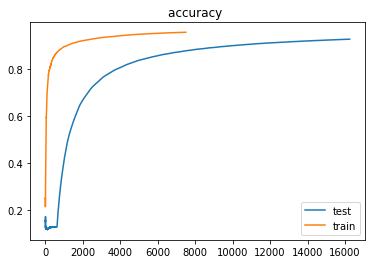

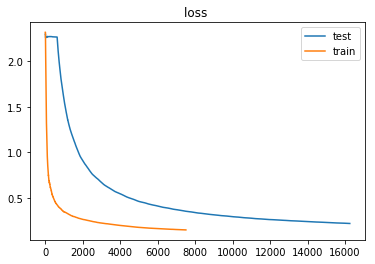

In [13]:
def backwards_mean(a):
    numpified = np.array(a)
    ret = np.copy(a)
    for i in range(1, len(a)):
        ret[i] = np.mean(numpified[0:i])
    return ret

def plot_curves(test_stats, train_stats, label=''):
    plt.figure()
    plt.plot(backwards_mean(test_stats['accuracy']), label='test')
    plt.plot(backwards_mean(train_stats['accuracy']), label='train')
    plt.legend()
    plt.title('accuracy ' + label)

    plt.figure()
    plt.plot(backwards_mean(test_stats['loss']), label='test')
    plt.plot(backwards_mean(train_stats['loss']), label='train')
    plt.legend()
    plt.title('loss ' + label)
    
plot_curves(test_stats, train_stats)

Try different variants!

* Does using a ConvNet improve performance (reduce overfitting?)
  * A conv net may also overfit like any other model. I don't see any difference in terms of the overfit from the MLP to LeNet5. We would have to combat overfitting with early stopping or regularization (dropout etc).
* Try changing the learning rate and observe the effect
  * When we increase the learning rate too much, the model is unable to learn anymore.
* Does the model train if you give it correlated gradients? (consecutively sample many batches of "1", then many batches of "2", ... etc
  * Assuming this question wants to turn of shuffle, then yes, it still learns. But this result is not intuitive, maybe the code is wrong. It should first fit ones, then goes towards twoes, then threes and so on.

## Trying convolutional net (LeNet5)

In [14]:
# Load data in 3d shape for convolutional net
train3d, test3d = chainer.datasets.get_mnist(ndim=3)

In [18]:
# Credits: https://docs.chainer.org/en/stable/examples/cnn.html#lenet5
class LeNet5(chainer.Chain):
    def __init__(self):
        super(LeNet5, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=1, out_channels=6, ksize=5, stride=1)
            self.conv2 = L.Convolution2D(in_channels=6, out_channels=16, ksize=5, stride=1)
            self.conv3 = L.Convolution2D(in_channels=16, out_channels=120, ksize=4, stride=1)
            self.fc4 = L.Linear(None, 84)
            self.fc5 = L.Linear(84, 10)

    def __call__(self, x):
        h = F.sigmoid(self.conv1(x))
        h = F.max_pooling_2d(h, 2, 2)
        h = F.sigmoid(self.conv2(h))
        h = F.max_pooling_2d(h, 2, 2)
        h = F.sigmoid(self.conv3(h))
        h = F.sigmoid(self.fc4(h))
        if chainer.config.train:
            return self.fc5(h)
        return F.softmax(self.fc5(h))

_,_ = better_run(LeNet5(), train=train3d, test=test3d)

epoch: 0, itr:    0 | TRAIN: accuracy: 0.062500, loss: 2.433042 | TEST: accuracy: 0.101000, loss: 2.340546
epoch: 0, itr:  300 | TRAIN: accuracy: 0.161960, loss: 2.271835 | TEST: accuracy: 0.230800, loss: 2.160354
epoch: 0, itr:  600 | TRAIN: accuracy: 0.425541, loss: 1.722067 | TEST: accuracy: 0.431133, loss: 1.669460
epoch: 0, itr:  900 | TRAIN: accuracy: 0.571448, loss: 1.327633 | TEST: accuracy: 0.546125, loss: 1.355326
epoch: 0, itr: 1200 | TRAIN: accuracy: 0.651957, loss: 1.090861 | TEST: accuracy: 0.619760, loss: 1.146255
epoch: 0, itr: 1500 | TRAIN: accuracy: 0.704031, loss: 0.933990 | TEST: accuracy: 0.671183, loss: 0.996395
epoch: 0, itr: 1800 | TRAIN: accuracy: 0.740769, loss: 0.820574 | TEST: accuracy: 0.708700, loss: 0.885777
epoch: 0, itr: 2100 | TRAIN: accuracy: 0.766599, loss: 0.737511 | TEST: accuracy: 0.738150, loss: 0.799051
epoch: 0, itr: 2400 | TRAIN: accuracy: 0.789281, loss: 0.668033 | TEST: accuracy: 0.761844, loss: 0.728533
epoch: 0, itr: 2700 | TRAIN: accuracy

## Trying different learning rates

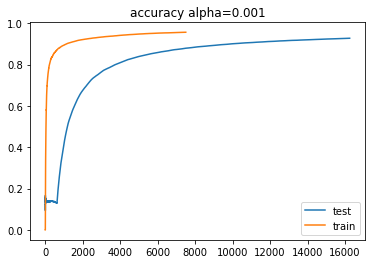

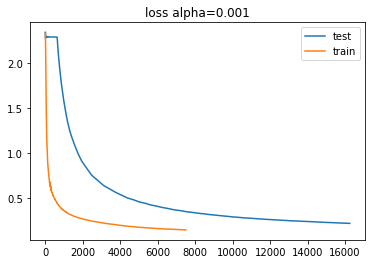

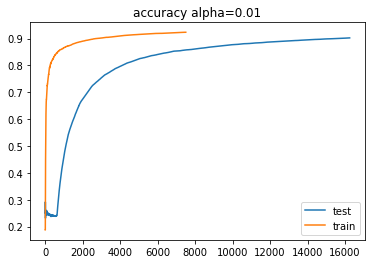

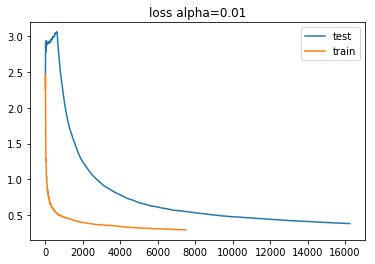

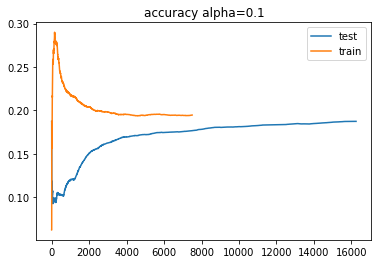

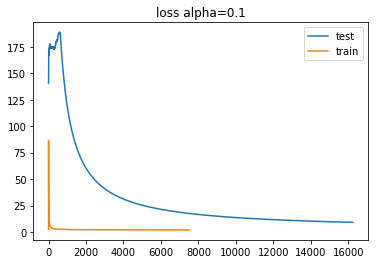

In [16]:
alphas = [0.001, 0.01, 0.1]

for alpha in alphas:
    train_stats, test_stats = better_run(MLP(200, 10), alpha=alpha, debug=False)
    plot_curves(test_stats, train_stats, 'alpha=' + str(alpha))

## Trying correlated gradients (e.g. training in order of classes)

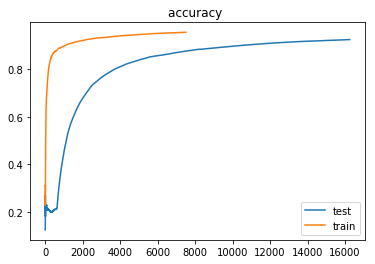

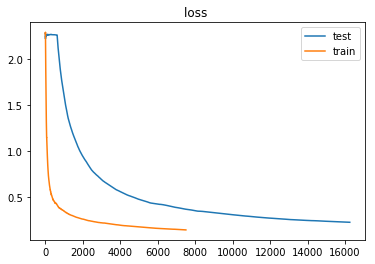

In [17]:
train_stats, test_stats = better_run(MLP(200, 10), shuffle=False, debug=False)
plot_curves(test_stats, train_stats)